In [2]:
import numpy as np
import pandas as pd
from polara import get_movielens_data

from ipypb import track

import seaborn as sns
sns.set_theme(style = 'white', context = 'paper')
%config InlineBackend.figure_format = 'retina'

In [3]:
data, genres_info = get_movielens_data(
    get_genres=True,
    split_genres=False,
    include_time=True
)

In [4]:
movies = genres_info.set_index('movieid')
movies.head()

,movienm,genres
movieid,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [5]:
groupped = data.groupby('movieid').size().reset_index().rename(columns={0: 'count'})
sum(groupped['count'] == 1)

114

In [6]:
interactions = pd.read_csv('KION_DATASET/interactions.csv')

In [7]:
data = interactions.rename(columns={"user_id": "userid", "item_id": "movieid", "watched_pct": "rating", "last_watch_dt": "timestamp"})

In [8]:
data

,userid,movieid,timestamp,total_dur,rating
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0
...,...,...,...,...,...
1594782,63645,16373,2021-04-20,30964.0,100.0
1594783,90242,15739,2021-07-27,12265.0,100.0
1594784,32937,10954,2021-05-13,71.0,1.0
1594785,311112,4151,2021-07-06,1480.0,13.0


In [9]:
"2021-05-09".replace("-", '')

'20210509'

In [10]:
data['timestamp'] = [int(n.replace("-", '')) for n in data['timestamp']]

In [11]:
data

,userid,movieid,timestamp,total_dur,rating
0,176549,9506,20210511,4250.0,72.0
1,699317,1659,20210529,8317.0,100.0
2,656683,7107,20210509,10.0,0.0
3,864613,7638,20210705,14483.0,100.0
4,964868,9506,20210430,6725.0,100.0
...,...,...,...,...,...
1594782,63645,16373,20210420,30964.0,100.0
1594783,90242,15739,20210727,12265.0,100.0
1594784,32937,10954,20210513,71.0,1.0
1594785,311112,4151,20210706,1480.0,13.0


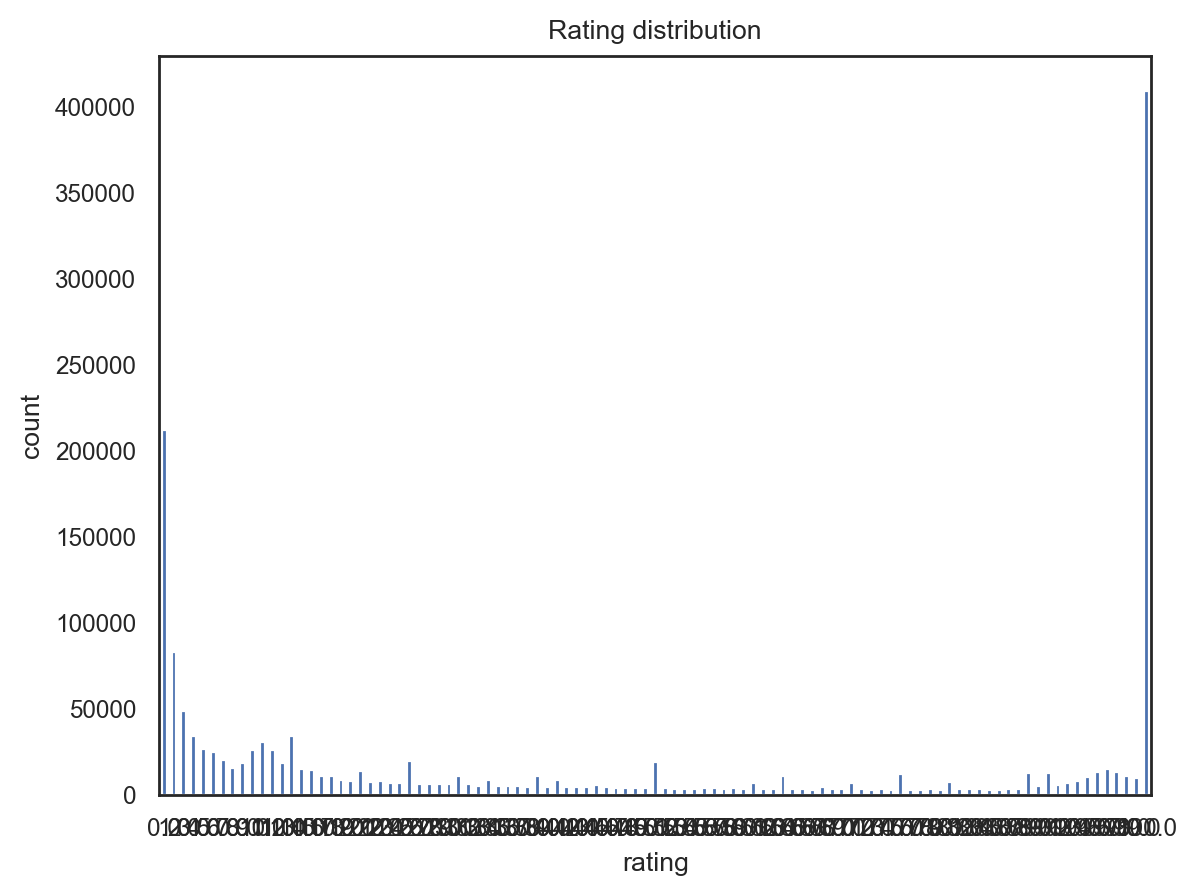

In [12]:
(
    data["rating"]
    .value_counts()
    .sort_index()
    .plot.bar(
        title = 'Rating distribution',
        xlabel = 'rating', ylabel = 'count',
        rot = 0
    )
);

In [13]:
def leave_last_out(data, userid='userid', timeid='timestamp'):
    data_sorted = data.sort_values('timestamp')
    holdout = data_sorted.drop_duplicates(
        subset = ['userid'], keep = 'last'
    )
    remaining = data.drop(holdout.index)
    return remaining, holdout

In [14]:
training_, holdout_ = leave_last_out(data)

In [15]:
len(data)

1594787

In [16]:
len(training_)

1027199

In [17]:
holdout_ts = holdout_.set_index('userid')['timestamp']
training_ts = training_.groupby('userid')['timestamp'].max()
assert holdout_ts.ge(training_ts).all

In [18]:
def transform_indexes(data, users, items):
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        new_index, data_index[entity] = to_numeric_id(data, field)
        data = data.assign(**{f'{field}': new_index})
    return data, data_index
def to_numeric_id(data, field):
    idx_data = data[field].astype('category')
    print(type(idx_data))
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map
def reindex_data(data, data_index, fields=None):
    if fields is None:
        fields = data_index.keys()
    if isinstance(fields, str):
        fields = [fields]
    for field in fields:
        entity = data_index[field].name
        new_index = data_index[field].get_indexer(data[entity])
        data = data.assign(**{f'{entity}': new_index})
    return data
        

In [19]:
training, data_index = transform_indexes(training_, 'userid', 'movieid')

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [20]:
len(training)

1027199

In [21]:
holdout = reindex_data(holdout_, data_index, ['users', 'items'])

In [22]:
holdout.sort_values('userid')

,userid,movieid,timestamp,total_dur,rating
943717,-1,1449,20210313,3044.0,5.0
1282052,-1,11031,20210712,12443.0,100.0
1002767,-1,7156,20210712,35.0,1.0
456157,-1,3037,20210712,15010.0,63.0
491121,-1,11228,20210712,8.0,0.0
...,...,...,...,...,...
987188,284994,7226,20210812,3042.0,53.0
780205,284995,11025,20210424,95.0,1.0
66824,284996,7360,20210618,198033.0,100.0
537061,284997,10269,20210821,3089.0,58.0


In [23]:
holdout.query('movieid >= 0')

,userid,movieid,timestamp,total_dur,rating
943717,-1,1449,20210313,3044.0,5.0
296441,-1,1341,20210313,5878.0,90.0
942193,-1,11797,20210313,8953.0,100.0
942050,-1,8253,20210313,7089.0,100.0
941517,-1,8253,20210313,5113.0,93.0
...,...,...,...,...,...
427769,126040,4975,20210822,1613.0,24.0
1353902,66558,2730,20210822,56.0,1.0
427772,101770,7287,20210822,5987.0,100.0
764790,258565,8540,20210822,91.0,0.0


In [24]:
#holdout.query('movieid < 0')['userid'].values

In [25]:
#training = training[~training['userid'].isin(holdout.query('movieid < 0')['userid'].values)]

In [26]:
#holdout_clean = holdout.query('movieid >= 0')
holdout_clean = holdout

In [27]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    test_users = holdout_clean[data_index['users'].name].values,
    feedback = 'rating'
)


In [33]:
data_description['test_users'][:100]

array([    -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
         4006,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
           -1,     -1, 248316,     -1,     -1,     -1,     -1,     -1,
           -1,     -1,     -1,     -1])

In [29]:
max(sorted(data_description['test_users']))

284998

SVD

In [30]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), dtype='f8')

def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values


def svd_model_scoring(params, test_data, data_description):
    item_factors, sigma = params
    test_matrix = matrix_from_observations(test_data, data_description)

    scores = (item_factors @ item_factors.T) @ test_matrix.T
    return scores.T


In [31]:
def simple_model_recom_func(scores, topn = 10, training = None):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations
def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]

In [31]:
for i in training:
    print(i)


userid
movieid
timestamp
total_dur
rating


Random model

In [32]:
def build_random_model(config, trainset, trainset_description):
    itemid = trainset_description['items']
    nitems = trainset[itemid].max() + 1
    random_state = np.random.RandomState(config['seed'])
    return nitems, random_state

In [33]:
def random_model_scoring(params, testset, testset_description):
    nitems, random_state = params
    nusers = len(testset_description['test_users'])
    scores = random_state.rand(nusers, nitems)
    return scores


In [34]:
from recommenders.utils.timer import Timer
with Timer() as train_time:
    rnd_params = build_random_model({'seed': 99}, training, data_description)
    rnd_scores = random_model_scoring(rnd_params, None, data_description)
    rnd_recoms = simple_model_recom_func(rnd_scores)

In [60]:
def display_movies(item_idx):
    movie_idx = data_index['items'][item_idx]
    return movies.loc[movie_idx]

In [61]:
display_movies(rnd_recoms[1])

,movienm,genres
movieid,,
2081,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
147,"Basketball Diaries, The (1995)",Drama
1439,Meet Wally Sparks (1997),Comedy
3546,What Ever Happened to Baby Jane? (1962),Drama|Thriller
2783,"Tomb of Ligeia, The (1965)",Horror
3190,Supernova (2000),Adventure|Sci-Fi
199,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical
1670,Welcome To Sarajevo (1997),Drama|War
2159,Henry: Portrait of a Serial Killer (1990),Crime|Horror


Popularity model

In [34]:
def build_popularity_model(config, trainset, trainset_description):
    itemid = trainset_description['items']
    item_popularity = trainset[itemid].value_counts()
    return item_popularity

In [35]:
def popularity_model_scoring(params, testset, testset_description):
    item_popularity = params
    n_items = item_popularity.index.max() + 1
    popularity_scores = np.zeros(n_items)
    popularity_scores[item_popularity.index] = item_popularity.values
    n_users = len(testset_description['test_users'])
    scores = np.tile(popularity_scores, n_users).reshape(n_users, n_items)
    return scores

In [36]:
pop_params = build_popularity_model({}, training, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
pop_recoms = simple_model_recom_func(pop_scores)

: 

: 

In [65]:
display_movies(pop_recoms[10])

,movienm,genres
movieid,,
2858,American Beauty (1999),Comedy|Drama
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
480,Jurassic Park (1993),Action|Adventure|Sci-Fi
2028,Saving Private Ryan (1998),Action|Drama|War
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1270,Back to the Future (1985),Comedy|Sci-Fi


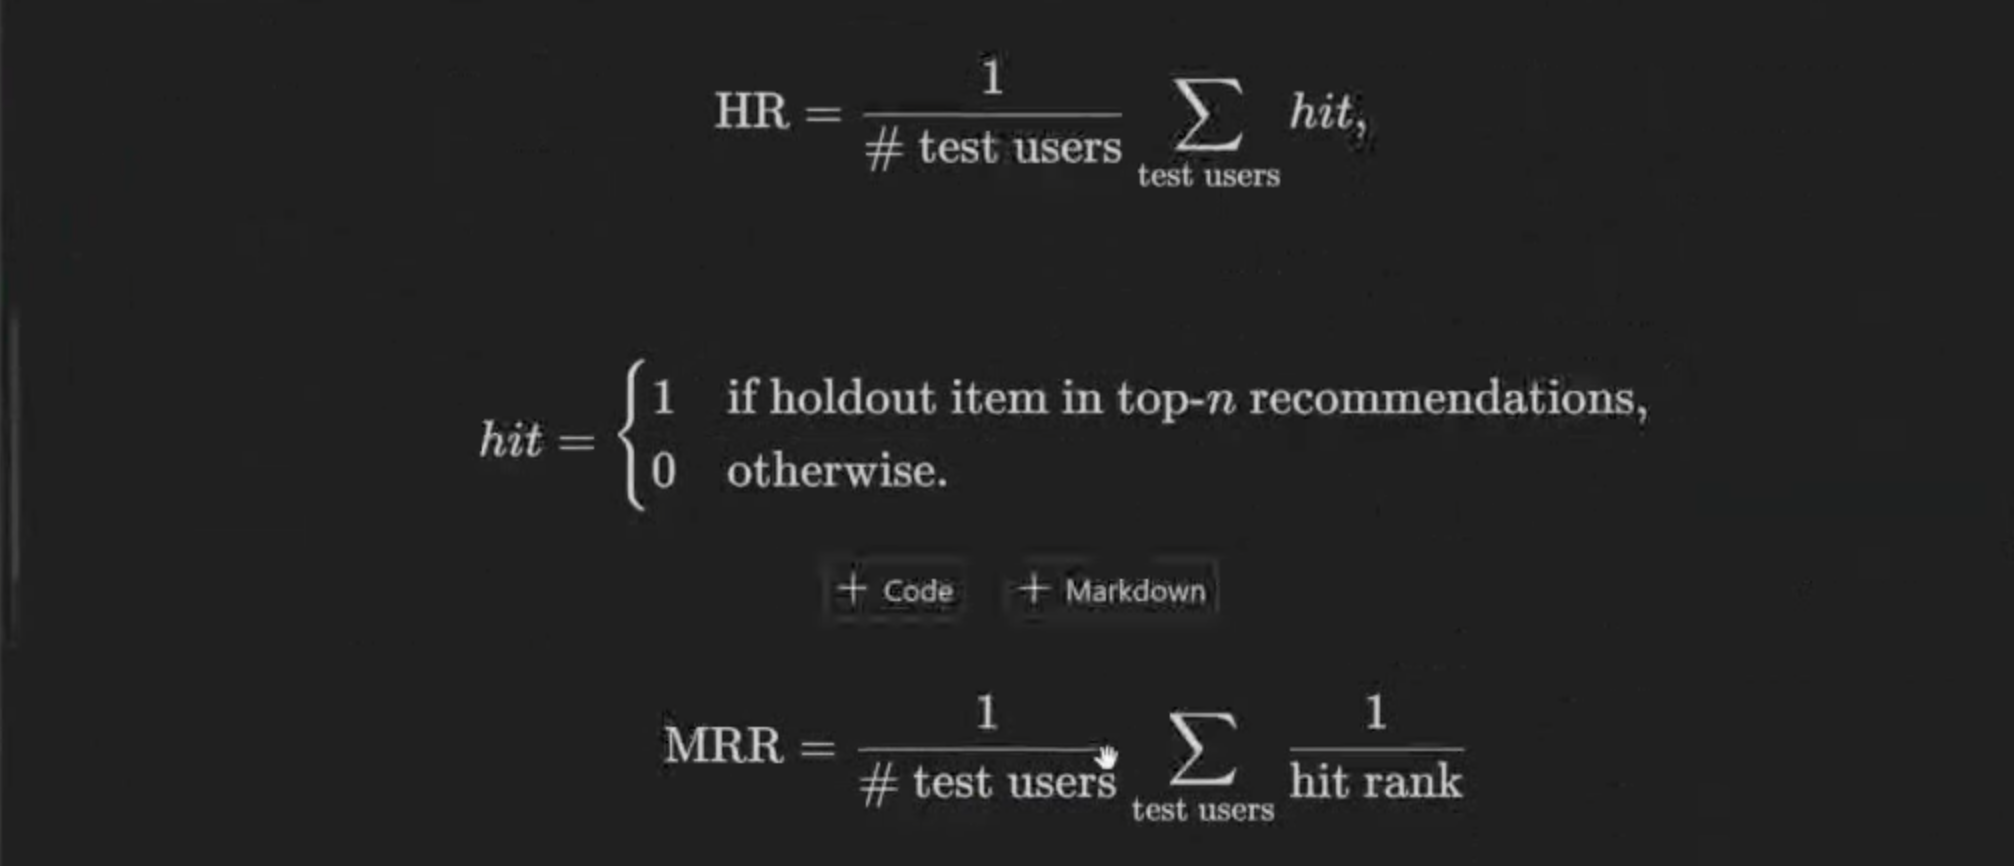

In [66]:
rnd_heat_mask = (
    rnd_recoms == holdout_clean['movieid'].values.reshape(-1, 1)
)


In [67]:
rnd_hr = rnd_heat_mask.any(axis = 1).mean()
rnd_hr

0.0013245033112582781

In [68]:
_, rnd_heat_rank = np.where(rnd_heat_mask)

In [69]:
n_test_users = len(data_description['test_users'])
rnd_mrr = (1. / (rnd_heat_rank + 1)).sum() / n_test_users
rnd_mrr

0.00037823241879533266

In [70]:
def model_evaluate(recommended_items, holdout, holdout_description, topn = 10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    #assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = (recommended_items[:, :topn] == holdout_items.reshape(-1, 1))

    hr = np.mean(hits_mask.any(axis = 1))

    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    return hr, mrr

In [71]:
model_evaluate(rnd_recoms, holdout_clean, data_description)

(0.0013245033112582781, 0.00037823241879533266)

In [72]:
model_evaluate(pop_recoms, holdout_clean, data_description)

(0.020364238410596026, 0.007024663618206664)

In [73]:
svd_params = build_svd_model({'rank': 600}, training, data_description)
svd_scores = svd_model_scoring(svd_params, training, data_description)
svd_recoms = simple_model_recom_func(svd_scores)

In [74]:
model_evaluate(svd_recoms, holdout_clean, data_description)

(0.016225165562913906, 0.004812230631767056)

In [75]:
from matplotlib.pyplot import *

In [1]:
svd_results_hr = []
svd_results_mrr = []
N = 50
for i in range(1, N):
    svd_params = build_svd_model({'rank': i}, training, data_description)
    svd_scores = svd_model_scoring(svd_params, training, data_description)
    svd_recoms = simple_model_recom_func(svd_scores)
    hr, mrr = model_evaluate(svd_recoms, holdout_clean, data_description)
    svd_results_hr.append(hr)
    svd_results_mrr.append(mrr)

NameError: name 'build_svd_model' is not defined

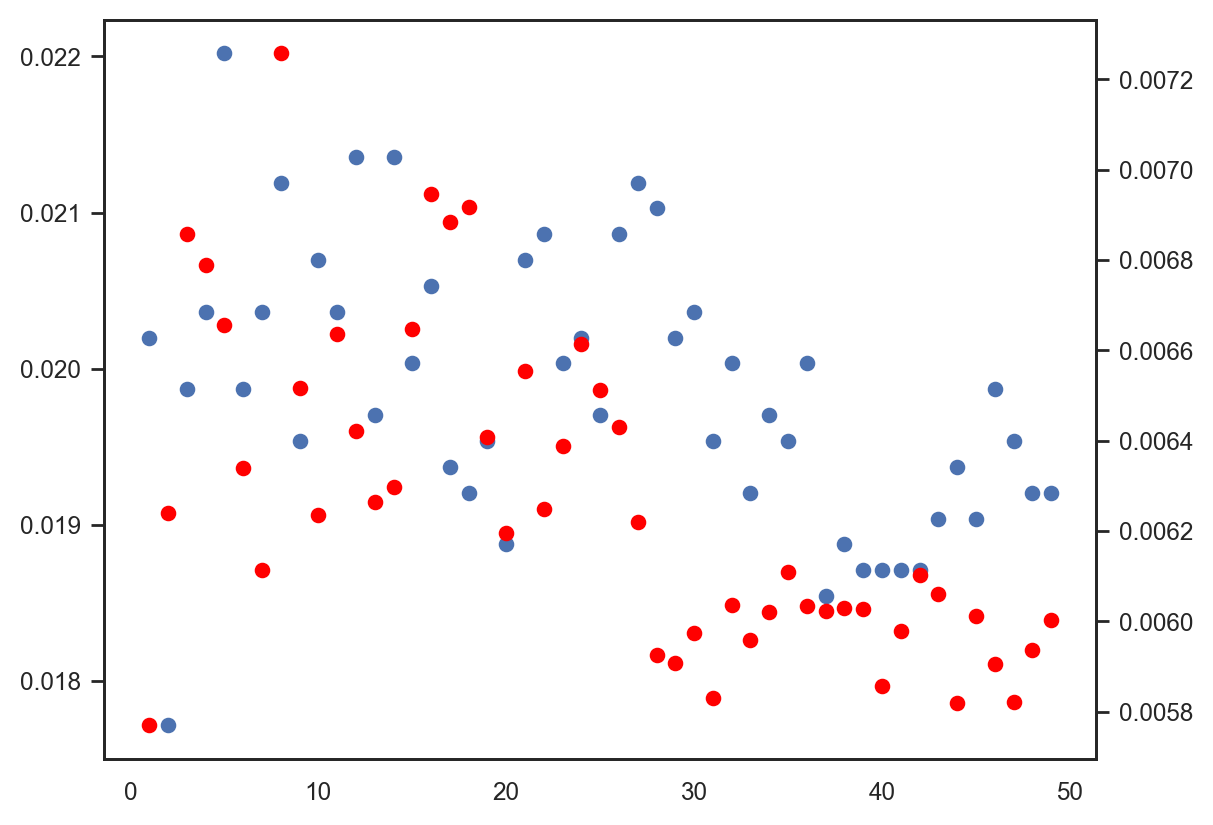

In [ ]:
fig, ax = subplots()
ax1 = ax.twinx()

ax.scatter(np.arange(1, N), svd_results_hr)
ax1.scatter(np.arange(1, N), svd_results_mrr, color = 'red')



In [ ]:
import FM

In [ ]:
training_renamed = training.rename(columns = {'userid': 'user_id', 'movieid': 'item_id'}, errors="raise")

In [ ]:
FM.FM(training_renamed)

TypeError: __init__() missing 1 required positional argument: 'args'